In [2]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
import re

import torch
import jieba
import jieba.analyse


import os

import matplotlib as mpl
from matplotlib.font_manager import fontManager

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from community import community_louvain

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BertTokenizer, BertModel, BertForMaskedLM

In [6]:
def keep_chinese_chars(text):
    pattern = re.compile(r'[^\u4e00-\u9fff]')
    chinese_text = re.sub(pattern, '', text)
    chinese_text = chinese_text.replace("推推", "")
    return chinese_text

def Mistral_summarize(text):

  device = "cuda" # the device to load the model onto

  model = AutoModelForCausalLM.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")
  tokenizer = AutoTokenizer.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")

  messages = [
      {"role": "user", "content": "What is your favourite condiment?"},
      {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
      {"role": "user", "content": {text}}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)

  return decoded

def bart_summarize(text):

    keep_chinese_chars(text)

    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
    model = BertForMaskedLM.from_pretrained('hfl/chinese-bert-wwm')

    inputs = tokenizer(text, return_tensors="pt", max_length=100, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=128)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def remove_spaces(text):
    # 使用 replace 方法來刪除空格
    return text.replace(" ", "")

def extract_keywords(text):
    #text = keep_chinese_chars(text)

    summary = bart_summarize(text)
    outputt_ext = remove_spaces(summary)

    return jieba.analyse.extract_tags(outputt_ext, topK=10)  # 提取前十個關鍵字


In [7]:
url = 'https://udn.com/news/index'
response = requests.get(url)
print(response.status_code)
if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')

#擷取即時和熱門新聞
b_tags = soup.find_all('span', class_="tab-link__title")
for tag in b_tags:
    if(tag.string!=None):
        print(tag.string)

200
聯準會決策出爐 ！利率連六度按兵不動 放慢縮表速度
哥倫比亞軍隊遺失逾1百萬顆子彈 疑軍方賣給軍火商
台中南屯設計公司暗夜起火 幸無人員傷亡僅家具燒毀
羽球／湯姆斯盃不敵日本 中華隊男團分組第2晉8強
影／台中南屯倉庫暗夜大火 烈焰燒百坪警消急疏散住戶
陸戰66旅戰車營士兵偷同袍萬餘元現金 提早退伍吃官司
老翁捷運削竹筍遭罰1萬 北市議員霸氣出手：我幫他繳
湳洋鍋物「14種肉品通通5折」！4款聯名餐點新上桌
哈瑪斯即將回覆停火提案 稱不願屈服以方條件
陸軍士官督導長今交接 原任李家緯遭調教官傳申報退役
陸軍司令交辦事項逾年未見起色 大動作整頓士督長體系
國道開了337趟未繳通行費 女駕駛見愛車被貼封條態度丕變
陳耀祥今立院備詢場面火爆  黃國昌：陳把NCC拉起來跟立法院對幹
金門酒廠首發原罈原漿年份高粱 全家便利商店獨家預購
獨／已婚大叔台中旗艦摩鐵丟命...同房輕熟女成目擊者
今明首波梅雨鋒 吳德榮：颮線將進入中南部 伴隨密集閃電
今天媽祖生！祭祀攻略一次看 記得供桌旁不能有「這東西」
網路出現影射蕭美琴緋聞文章 國安局：曾報告國安會


In [8]:
#dataframe 和 dict
list1=[]
list2=[]

b_tags = soup.find_all('a', class_="tab-link")
for tag in b_tags:
    c_tag = tag.find('span', class_="tab-link__title")
    if(c_tag.string!=None):
        #print(c_tag.string)
        list1.append(c_tag.string)
        if 'href' in tag.attrs:

            #切換至連結的頁面
            new_url = tag.get('href')
            response = requests.get(new_url)
            #print(new_url)

            if response.status_code == 200:
                soupp = BeautifulSoup(response.text, 'html.parser')

                #截取內容
                d_tags = soupp.find_all('p')
                str=""
                for tagg in d_tags:

                    if(str!=""):
                        str=str+""+tagg.text
                    else:
                        str=tagg.text
                    #print(str)

                list2.append(str)

In [9]:
#dataframe
df = pd.DataFrame({
    'Title': list1,
    'Text': list2,
})
df

,Title,Text
0,聯準會決策出爐 ！利率連六度按兵不動 放慢縮表速度,聯準會（Fed）在美東時間1日下午2時（台灣時間2日凌晨2時）結束一連兩天的政策會議，並發布...
1,哥倫比亞軍隊遺失逾1百萬顆子彈 疑軍方賣給軍火商,哥倫比亞總統裴卓近日指出，軍方武器庫存顯示，有超過100萬顆子彈、數以千計爆裂物在軍事基地遺...
2,台中南屯設計公司暗夜起火 幸無人員傷亡僅家具燒毀,台中市南屯區環中路四段一間鐵皮倉庫，昨天深夜11時許傳出火警，消防局派遣多個分隊前往滅火，火...
3,羽球／湯姆斯盃不敵日本 中華隊男團分組第2晉8強,湯優盃男、女羽球團體賽在中國成都繼續進行，中華隊男團今天在湯姆斯盃預賽最後1戰以0比5遭到日...
4,影／台中南屯倉庫暗夜大火 烈焰燒百坪警消急疏散住戶,\n台中市南屯區環中路四段的一間鐵皮倉庫在昨天深夜11時許傳出火警，火勢猛烈，消防局派遣勤工...
5,陸戰66旅戰車營士兵偷同袍萬餘元現金 提早退伍吃官司,蔡姓男子原在海軍陸戰隊陸戰66旅、別名「陸戰先鋒66旅」下湖營區服役的職業軍人，疑因在外積欠...
6,老翁捷運削竹筍遭罰1萬 北市議員霸氣出手：我幫他繳,北捷淡水線4月22日傍晚6點接獲民眾通報車廂內有人亮刀情況，捷運警察隊到場發現竟然是名老翁，...
7,湳洋鍋物「14種肉品通通5折」！4款聯名餐點新上桌,隨著母親節即將到來，黑浮國際餐飲旗下的「湳洋鍋物」限時推出「肉品全系列5折」的限時加購優惠。...
8,哈瑪斯即將回覆停火提案 稱不願屈服以方條件,巴勒斯坦武裝團體哈瑪斯正在考慮一項與以色列停火40天及人質換囚的計畫。法新社1日報導，哈瑪斯...
9,陸軍士官督導長今交接 原任李家緯遭調教官傳申報退役,陸軍司令部士官督導長異動，今（1）日舉行交接儀式，原督導長李家緯未繼續往參謀本部等高司任職，...


In [10]:
df['Keywords'] = df['Text'].apply(extract_keywords)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.861 seconds.
DEBUG:jieba:Loading model cost 0.861 seconds.
Prefix dic

In [11]:
df

,Title,Text,Keywords
0,聯準會決策出爐 ！利率連六度按兵不動 放慢縮表速度,聯準會（Fed）在美東時間1日下午2時（台灣時間2日凌晨2時）結束一連兩天的政策會議，並發布...,"[時間, 聯邦, 公開, 聯準, fed, 美東, 台灣, 結束, 一連, 兩天]"
1,哥倫比亞軍隊遺失逾1百萬顆子彈 疑軍方賣給軍火商,哥倫比亞總統裴卓近日指出，軍方武器庫存顯示，有超過100萬顆子彈、數以千計爆裂物在軍事基地遺...,"[哥倫比亞, 裴卓, 軍方, 武器, 總統, 庫存, 顯示, 超過, 100, 萬顆]"
2,台中南屯設計公司暗夜起火 幸無人員傷亡僅家具燒毀,台中市南屯區環中路四段一間鐵皮倉庫，昨天深夜11時許傳出火警，消防局派遣多個分隊前往滅火，火...,"[一間, 鐵皮, 鋼筋, 平方公尺, 南屯區環, 倉庫, 11, 時許, 傳出, 消防局]"
3,羽球／湯姆斯盃不敵日本 中華隊男團分組第2晉8強,湯優盃男、女羽球團體賽在中國成都繼續進行，中華隊男團今天在湯姆斯盃預賽最後1戰以0比5遭到日...,"[天是, 中華隊, 男團, 湯姆斯, 確定, 今天, 湯優, 羽球, 團體賽, 中國]"
4,影／台中南屯倉庫暗夜大火 烈焰燒百坪警消急疏散住戶,\n台中市南屯區環中路四段的一間鐵皮倉庫在昨天深夜11時許傳出火警，火勢猛烈，消防局派遣勤工...,"[台電, 消防局, 南屯區環, 一間, 鐵皮, 倉庫, 11, 時許, 傳出, 火勢]"
5,陸戰66旅戰車營士兵偷同袍萬餘元現金 提早退伍吃官司,蔡姓男子原在海軍陸戰隊陸戰66旅、別名「陸戰先鋒66旅」下湖營區服役的職業軍人，疑因在外積欠...,"[蔡姓, 陸戰, 66, 女兒, 男子, 同袍, 海軍陸, 戰隊, 別名, 先鋒]"
6,老翁捷運削竹筍遭罰1萬 北市議員霸氣出手：我幫他繳,北捷淡水線4月22日傍晚6點接獲民眾通報車廂內有人亮刀情況，捷運警察隊到場發現竟然是名老翁，...,"[北捷, 老翁, 苦人, 22, 點接, 獲民眾, 通報, 車廂, 亮刀, 情況]"
7,湳洋鍋物「14種肉品通通5折」！4款聯名餐點新上桌,隨著母親節即將到來，黑浮國際餐飲旗下的「湳洋鍋物」限時推出「肉品全系列5折」的限時加購優惠。...,"[泰式, 洋鍋物, 限時, 菜色, 隨著母, 親節, 將到, 黑浮, 國際餐, 加購]"
8,哈瑪斯即將回覆停火提案 稱不願屈服以方條件,巴勒斯坦武裝團體哈瑪斯正在考慮一項與以色列停火40天及人質換囚的計畫。法新社1日報導，哈瑪斯...,"[代表, 哈瑪斯, 停火, 辛迪, 武裝, 團體, 考慮, 一項, 40, 天及]"
9,陸軍士官督導長今交接 原任李家緯遭調教官傳申報退役,陸軍司令部士官督導長異動，今（1）日舉行交接儀式，原督導長李家緯未繼續往參謀本部等高司任職，...,"[調任, 士官, 李家, 同袍, 督導長, 異動, 日舉行, 儀式, 原督導長, 緯未]"


In [37]:
G = nx.Graph()

for index, row in df.iterrows():

  author = row['Title']
  keywords = row['Keywords']

  G.add_node(author, type='author')

  for keyword in keywords:
    G.add_node(keyword, type='keywords')
    G.add_edge(author, keyword)

In [38]:
keywords

['阿美族', '名為', '總統', '立委', '立院', '徐巧', '國防委員會', '質詢', '國安局', '蔡明彥']

In [39]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
# 改style要在改font之前
# plt.style.use('seaborn')
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-05-01 20:39:47--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.111.101, 142.251.111.138, 142.251.111.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.111.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-05-01 20:39:47--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.122.132, 2607:f8b0:4004:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.122.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-05-01 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


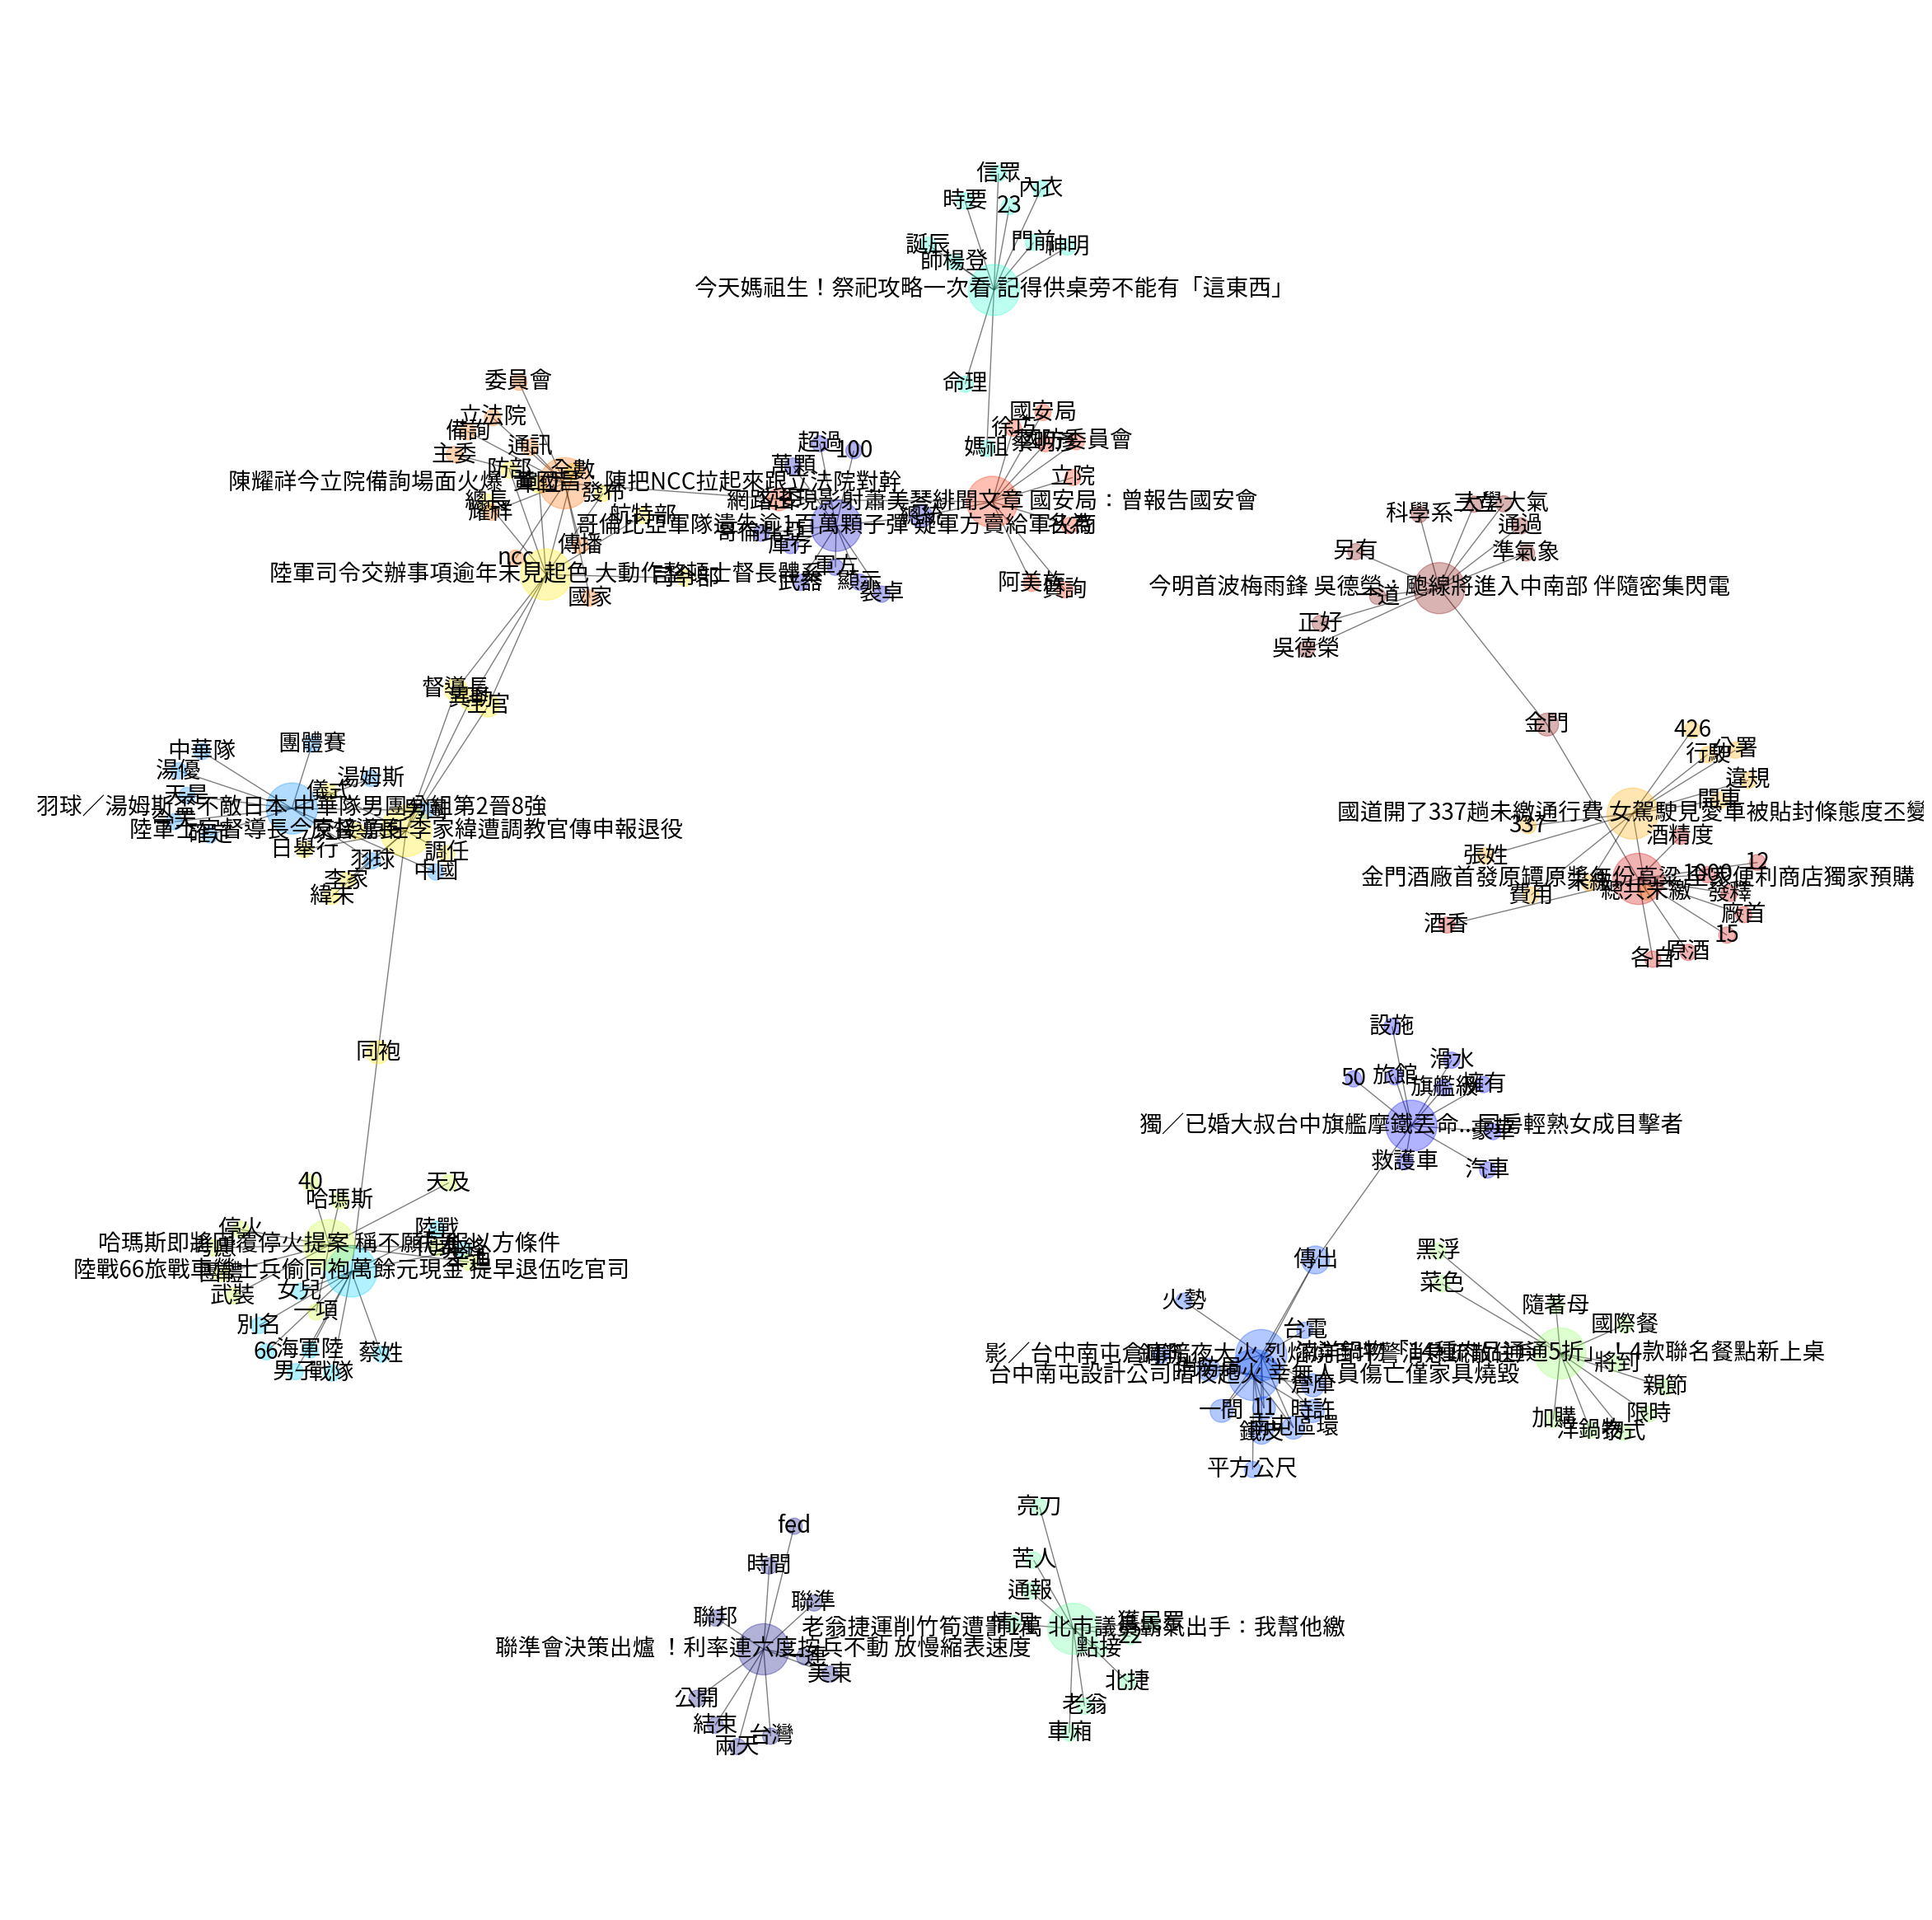

In [40]:
partition = community_louvain.best_partition(G)

community_colors = [partition[node] for node in G.nodes()]

cmap = plt.cm.jet
colors_with_alpha = [cmap(community_color / (max(community_colors)+0.1)) for community_color in community_colors]

colors_with_alpha = [(r, g, b, 0.3) for r, g, b, _ in colors_with_alpha]

node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.2, iterations=80)

plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')

plt.axis('off')
plt.show()